# Data Science Technology and Systems
### Assignment 1: Part B - Predictive Modelling
##### Sumedha Verma (u3214504) 

In [1]:
# Import Libraries 
import os
import re
import numpy as np
import pandas as pd 
from collections import Counter

# Plotting Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modelling Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [2]:
# Load Data
data = pd.read_csv('data/zomato_df_final_data.csv')
data.head()

address   cost  \
0                      371A Pitt Street, CBD, Sydney   50.0   
1      Shop 7A, 2 Huntley Street, Alexandria, Sydney   80.0   
2   Level G, The Darling at the Star, 80 Pyrmont ...  120.0   
3   Sydney Opera House, Bennelong Point, Circular...  270.0   
4              20 Campbell Street, Chinatown, Sydney   55.0   

                                       cuisine        lat  \
0   ['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean'] -33.876059   
1  ['Cafe', 'Coffee and Tea', 'Salad', 'Poké'] -33.910999   
2                                 ['Japanese'] -33.867971   
3                        ['Modern Australian'] -33.856784   
4                            ['Thai', 'Salad'] -33.879035   

                                                link         lng  \
0    https://www.zomato.com/sydney/sydney-madang-cbd  151.207605   
1  https://www.zomato.com/sydney/the-grounds-of-a...  151.193793   
2        https://www.zomato.com/sydney/sokyo-pyrmont  151.195210   
3  https://www.zomato.com/sydney/bennelong-restau...  151.215297   
4  https://www.zomato.com/sydney/chat-thai-chinatown  151.206409   

          phone  rating_number rating_text  \
0  02 8318 0406            4.0   Very Good   
1  02 9699 2225            4.6   Excellent   
2  1800 700 700            4.9   Excellent   
3  02 9240 8000            4.9   Excellent   
4  02 8317 4811            4.5   Excellent   

                                 subzone                           title  \
0                                    CBD                   Sydney Madang   
1  The Grounds of Alexandria, Alexandria  The Grounds of Alexandria Cafe   
2                      The Star, Pyrmont                           Sokyo   
3                          Circular Quay            Bennelong Restaurant   
4                              Chinatown                       Chat Thai   

                     type   votes  groupon    color     cost_2 cuisine_color  
0       ['Casual Dining']  1311.0    False  #e15307   5.243902       #6f706b  
1                ['Café']  3236.0    False  #9c3203   7.560976       #6f706b  
2         ['Fine Dining']  1227.0    False  #7f2704  10.650407       #6f706b  
3  ['Fine Dining', 'Bar']   278.0    False  #7f2704  22.235772       #4186f4  
4       ['Casual Dining']  2150.0    False  #a83703   5.630081       #6f706b

#### I. Feature Engineering
(1) Feature engineering to impute records that are null to make them useful in the model. 

Imputation will be used here rather than removal since removal will result in important data being lost 

In [3]:
# Split data into cateforical and numerical variables since different imputation methods will be applied
categorical = [var for var in data.columns if data[var].dtypes == 'O']
numericals = [var for var in data.columns if data[var].dtypes != 'O']
print(categorical)

['address', 'cuisine', 'link', 'phone', 'rating_text', 'subzone', 'title', 'type', 'color', 'cuisine_color']


In [4]:
# DEALING WITH NULL VALUES  
# display numper of null values
print('The number of nulls in each column of the Data Frame')
data.isnull().sum()

The number of nulls in each column of the Data Frame


address             0
cost              346
cuisine             0
lat               192
link                0
lng               192
phone               0
rating_number    3316
rating_text      3316
subzone             0
title               0
type               48
votes            3316
groupon             0
color               0
cost_2            346
cuisine_color       0
dtype: int64

In [5]:
# The median value of each column will be imputed into the null values 
# The median is used over mean since it is more robust to outliers 
for df_temp in [data]:
    for col in numericals:
        col_median = data[col].median() # get it only from training
        df_temp[col].fillna(col_median, inplace=True)

In [6]:
# The mode (most frequent value in each category) will be imputed into the null values  
for df_temp in [data]:
    for col in categorical:
        col_mode = data[col].mode()[0] # get it only from training
        df_temp[col].fillna(col_mode, inplace=True)

In [7]:
# checking number of nulls
print('The number of nulls in each column of the Data Frame after imputation')
data.isnull().sum()

The number of nulls in each column of the Data Frame after imputation


address          0
cost             0
cuisine          0
lat              0
link             0
lng              0
phone            0
rating_number    0
rating_text      0
subzone          0
title            0
type             0
votes            0
groupon          0
color            0
cost_2           0
cuisine_color    0
dtype: int64

(2) Feature engineering to encode categorical variables 

Binary encoding will be used for binary variables and One hot-encoding will be used for categorical variables with more than one category. 

In [8]:
# PRINT DATA TYPES 
data.dtypes

address           object
cost             float64
cuisine           object
lat              float64
link              object
lng              float64
phone             object
rating_number    float64
rating_text       object
subzone           object
title             object
type              object
votes            float64
groupon             bool
color             object
cost_2           float64
cuisine_color     object
dtype: object

The only binary variable in the data is the 'groupon' variable (dtype = bool). Hence, binary encoding can be applied to this variable. Further, the category encoders pack did not work on my computer, hence, this binary encoding was done manually 

In [9]:
# Encoding the binary variable groupon
data['groupon'] = data['groupon'].replace({False:0, True:1})

# import category_encoders as ce
#encoder = ce.BinaryEncoder(cols=['groupon'])
#data = encoder.fit_transform(data)
#print(data['groupon'])

A lot of the categorical variables in this data consist of many unique category values, like address, link, suburbs. The only variable with a smaller amount of categories is the rating variable. Hence only the rating text variable is one-hot encoded. 

These variables will only be use for regression and not for classification, since this is the target variable for classification. Although, if the rating text is known, predicting the actual rating number should not be too difficult and might be pointless

In [10]:
# one-hot-encoding using pandas for rating_text
# creating the features
rating = pd.get_dummies(data['rating_text'], drop_first=False, dummy_na=True)
# concatenating the created features
data = pd.concat([data,rating], axis = 1)
data.head()

address   cost  \
0                      371A Pitt Street, CBD, Sydney   50.0   
1      Shop 7A, 2 Huntley Street, Alexandria, Sydney   80.0   
2   Level G, The Darling at the Star, 80 Pyrmont ...  120.0   
3   Sydney Opera House, Bennelong Point, Circular...  270.0   
4              20 Campbell Street, Chinatown, Sydney   55.0   

                                       cuisine        lat  \
0   ['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean'] -33.876059   
1  ['Cafe', 'Coffee and Tea', 'Salad', 'Poké'] -33.910999   
2                                 ['Japanese'] -33.867971   
3                        ['Modern Australian'] -33.856784   
4                            ['Thai', 'Salad'] -33.879035   

                                                link         lng  \
0    https://www.zomato.com/sydney/sydney-madang-cbd  151.207605   
1  https://www.zomato.com/sydney/the-grounds-of-a...  151.193793   
2        https://www.zomato.com/sydney/sokyo-pyrmont  151.195210   
3  https://www.zomato.com/sydney/bennelong-restau...  151.215297   
4  https://www.zomato.com/sydney/chat-thai-chinatown  151.206409   

          phone  rating_number rating_text  \
0  02 8318 0406            4.0   Very Good   
1  02 9699 2225            4.6   Excellent   
2  1800 700 700            4.9   Excellent   
3  02 9240 8000            4.9   Excellent   
4  02 8317 4811            4.5   Excellent   

                                 subzone  ... groupon    color     cost_2  \
0                                    CBD  ...       0  #e15307   5.243902   
1  The Grounds of Alexandria, Alexandria  ...       0  #9c3203   7.560976   
2                      The Star, Pyrmont  ...       0  #7f2704  10.650407   
3                          Circular Quay  ...       0  #7f2704  22.235772   
4                              Chinatown  ...       0  #a83703   5.630081   

   cuisine_color Average  Excellent Good  Poor  Very Good  NaN  
0        #6f706b       0          0    0     0          1    0  
1        #6f706b       0          1    0     0          0    0  
2        #6f706b       0          1    0     0          0    0  
3        #4186f4       0          1    0     0          0    0  
4        #6f706b       0          1    0     0          0    0  

[5 rows x 23 columns]

For creating more descriptive features in the data, binary variables are created next. if an observation's suburb includes the word 'CBD' it is flagged for being in a city. If it contain's the word 'beach,' it is flagged for being by the beach. The better way to classify suburbs should be to group suburbs together using a map, however, I ran out of time. Hence, I did it by words in suburb names. These features are used instead of one-hot-encoding the data to keep the dimensions of the data from increasing too much as some models do not work well with high dimensional data (also my laptop struggles with high-dimensional data)

In [11]:
# creating location-descriptive variables
data['city'] = np.where(data['subzone'].str.contains('CBD'), 1, 0)
data['beach'] = np.where(data['subzone'].str.contains('beach'), 1, 0)
data['food_court'] = np.where(data['subzone'].str.contains('foodcourt'), 1, 0)
data['shopping_center'] = np.where(data['subzone'].str.contains('shopping'), 1, 0)
data['chinatown'] = np.where(data['subzone'].str.contains('Chinatown'), 1, 0)

Also to look get a clearer picture of the cuisine, instead of one-hot encoding the large list-column, I decided to create flags for the top 5 most popular cuisines in Australia. The top 5 cuisines in Australia were found using https://www.chefspencil.com/most-popular-ethnic-cuisine-in-australia/

These could be a more useful version of the cuisine variable. one-hot encoding the cuisine variable would again create high dimensions in the data, hence flagging the top 5 most popular cuisines is a simpler solution. Also the type variable will be properly one -hot encoded since there are only 15 unique values 

In [12]:
# creating cuisine-descriptive variables
data['thai'] = np.where(data['cuisine'].str.contains('Thai'), 1, 0)
data['chinese'] = np.where(data['cuisine'].str.contains('Chinese'), 1, 0)
data['italian'] = np.where(data['cuisine'].str.contains('Italian'), 1, 0)
data['japanese'] = np.where(data['cuisine'].str.contains('japanese'), 1, 0)
data['indian'] = np.where(data['cuisine'].str.contains('Indian'), 1, 0)

In [13]:
# One hot encoding the type variable
data['bakery'] = np.where(data['type'].str.contains('Bakery'), 1, 0)
data['bar'] = np.where(data['type'].str.contains('Bar'), 1, 0)
data['beverage'] = np.where(data['type'].str.contains('Beverage'), 1, 0)
data['cafe'] = np.where(data['type'].str.contains('Caf'), 1, 0)
data['casual'] = np.where(data['type'].str.contains('Casual'), 1, 0)
data['stall'] = np.where(data['type'].str.contains('Stall'), 1, 0)
data['truck'] = np.where(data['type'].str.contains('Truck'), 1, 0)
data['pub'] = np.where(data['type'].str.contains('Pub'), 1, 0)
data['wine'] = np.where(data['type'].str.contains('Wine'), 1, 0)
data['club'] = np.where(data['type'].str.contains('Club'), 1, 0)
data['dessert'] = np.where(data['type'].str.contains('Dessert'), 1, 0)
data['fast'] = np.where(data['type'].str.contains('Fast'), 1, 0)
data['fine'] = np.where(data['type'].str.contains('Fine'), 1, 0)
data['court'] = np.where(data['type'].str.contains('Court'), 1, 0)

#### Regression

To compute linear regression, for predicting the numerical rating variables, the following steps are computed below: 
* feature selection
* data split 
* compute model
* compute model performance metric

In [14]:
# select the variables to be used for regression 
# select predictor variables
x_var = data[['cost','lat', 'lng',  'votes', 'groupon', 'beach', 'city', 'food_court', 
                 'shopping_center', 'Average', 'Excellent', 'Good', 'Poor', 'Very Good', 'chinatown', 'thai', 
                 'chinese', 'italian', 'japanese', 'indian', 'bakery', 'bar', 'beverage', 'cafe', 'casual',
             'stall', 'truck', 'pub', 'wine', 'club', 'dessert', 'fast', 'fine', 'court']]

# select output variables
y_var = data['rating_number']


In [15]:
# data split into training and testing (for x and y) with 20% assigned to testing, and 80% to training
x_train, x_test, y_train, y_test = train_test_split(x_var, y_var, test_size = 0.2, random_state = 0)

(3) Building a linear regression model to predict restaurants numeric ratings 

In [16]:
# compute the linear regression model
model_regression_1 = LinearRegression().fit(x_train, y_train)

# compute predictions using the regression model 
model_1_pred = model_regression_1.predict(x_test)

(4) Building another linear regression model using Gradient Descent for optimisation

In [17]:
# compute the gradient descent model
model_regression_2 = SGDRegressor().fit(x_train, y_train)

# compute predictions using this model 
model_2_pred = model_regression_2.predict(x_test)

(5) Comparing the mean square errors of the model's predictions 

In [18]:
mse_1 = mean_squared_error(y_test,model_1_pred)
mse_2 = mean_squared_error(y_test,model_2_pred)

print('The mean square error of linear regression model is: ' + str(mse_1))
print('The mean square error of the model with gradient descent optimisation is: ' + str(mse_2))

The mean square error of linear regression model is: 0.03980412086296493
The mean square error of the model with gradient descent optimisation is: 6.812283391921303e+26


The mean square error of the linear regression model is significantly lower than the meansquare error of the gradient descent model. The MSE of the gradient descent is significantly large, which suggests that this is not an appropriate methodolgy for this prediction. The MSE of the linear regression model, being significantly lower, makes it more appropriate for predicting rating numbers using this data

#### III. Classification

For classifications, the rating one-hot encoded variables will be removed from the model, since this is the predictor variable. Also, the data will be split further into training and testing data sets 

In [19]:
# data feature selection
x_var = data[['cost','lat', 'lng',  'votes', 'groupon', 'beach', 'city', 'food_court', 
                 'shopping_center', 'chinatown', 'thai', 'chinese', 'italian', 'japanese', 'indian',
              'bakery', 'bar', 'beverage', 'cafe', 'casual',
             'stall', 'truck', 'pub', 'wine', 'club', 'dessert', 'fast', 'fine', 'court']]

# assigning the output variable
y_var = data['rating_text']

(6) Simplifying the problem to make the rating scores either - creating a boolean variable where, good and above ratings are 1 and the poor ratings are 0

In [20]:
# simplifying the output variable
y_var = y_var.replace({'Excellent':1, 'Very Good':1, 'Good':1, 'Average': 0, 'Poor':0})

# splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_var, y_var, test_size = 0.2, random_state = 0)

(7) Computing a logistic regression model

In [21]:
# initiate model
logreg = LogisticRegression(solver='liblinear', random_state=0)

# fit model
logreg.fit(x_train, y_train)

# computing predictions
log_pred = logreg.predict(x_test)

# compute accuracy score
log_accuracy = accuracy_score(y_test, log_pred)

(8) computing the confusion matrix to assess model performance

model accuracy score: 0.8838095238095238


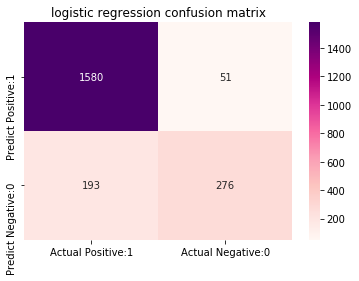

In [22]:
# computing the confusion matrix
cm = confusion_matrix(y_test, log_pred)

# visualize confusion matrix
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
# plot of the matrix
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdPu')
plt.title('logistic regression confusion matrix')

# compute accuracy score
print('model accuracy score: ' + str(log_accuracy))

The accuracy score of the logistic regression was 88.38 %. The performance of this classification based on location, cost and cuisine features can be considered to be good. The model does not have too many miss-classifications. This could be due to the assymetry in the data (more positive (1) values than negative (0) ratings). Hoever, this might not be the case since more of the miss-classifications are predicted negative compared to those miss-classified as positive. Hence, making this a reasonably good prediction model

#### Different Models 

The next model that will be tried is the k-means clustering model. similar computation steps will be applied 

model accuracy score: 0.8757142857142857


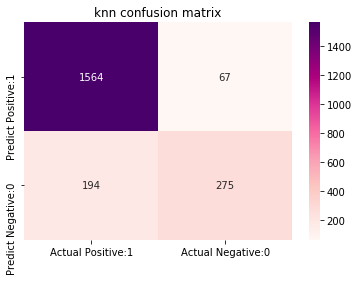

In [23]:
# instantiate the model
knn = KNeighborsClassifier(n_neighbors = 2)

# fit the model
knn.fit(x_train, y_train)

# compute predictions 
knn_pred = knn.predict(x_test)

# compute accuracy score
knn_accuracy = accuracy_score(y_test, knn_pred)

# compute confusion matrix
cm = confusion_matrix(y_test, knn_pred)

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdPu')
plt.title('knn confusion matrix')

# compute accuracy score
print('model accuracy score: ' + str(knn_accuracy))

Looking at the confusion matrix for this model, it can be observed that more data points are classified correctly. the number of points missclassified are evenly distributed amongst the two categories. The accuracy score for knn model is also higher than the logistic model

Next, the deicision tree model will be tried on the data 

model accuracy score: 0.8728571428571429


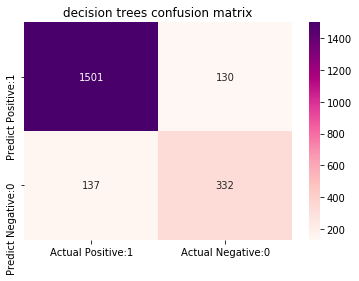

In [24]:
# instantiate the model
dtree = DecisionTreeClassifier(random_state = 0)

# fit the model
dtree.fit(x_train, y_train)

# compute predictions 
dtree_pred = dtree.predict(x_test)

# compute accuracy score
dtree_accuracy = accuracy_score(y_test, dtree_pred)

# compute confusion matrix
cm = confusion_matrix(y_test,dtree_pred)

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdPu')
plt.title('decision trees confusion matrix')

# compute accuracy score
print('model accuracy score: ' + str(dtree_accuracy))

The decision trees model performs worse than the knn and logistic regression model in terms of both accuracy scores, and the number of miss-classifications 

The next model that will be tested is Support Vector Machine

model accuracy score: 0.8828571428571429


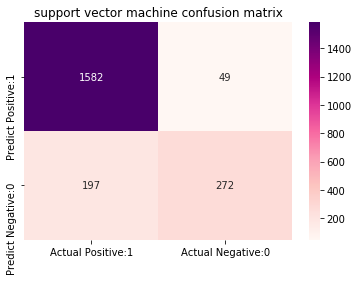

In [25]:
# instantiate the model
svm = make_pipeline(StandardScaler(), SVC(gamma = 'auto'))

# fit the model
svm.fit(x_train,y_train)

# compute predictions 
svm_pred = svm.predict(x_test)

# compute accuracy score
svm_accuracy = accuracy_score(y_test, svm_pred)

# compute confusion matrix
cm = confusion_matrix(y_test, svm_pred)

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdPu')
plt.title('support vector machine confusion matrix')

# compute accuracy score
print('model accuracy score: ' + str(svm_accuracy))

This model performs really well in accuracy and also in terms of miss-classifications, the accuracy score is almost as high as that for k nearest neighbours. 

In [26]:
print('logistic regression accuracy score: ' + str(log_accuracy))
print('knn accuracy score: ' + str(knn_accuracy))
print('decision tree accuracy score: ' + str(dtree_accuracy))
print('svm accuracy score: ' + str(svm_accuracy))

logistic regression accuracy score: 0.8838095238095238
knn accuracy score: 0.8757142857142857
decision tree accuracy score: 0.8728571428571429
svm accuracy score: 0.8828571428571429


The summary above shoes the accuracy scores for all models computed here. The highest is for logistic regression. Hence, It can be concluded, that in terms of model prediction accuracy, logistic regression algorithm performs the best in classifying restaurats to either good or poor. 

In the following section, instead of two classes for the output variable, 5 classes for each rating will be used to check if the model performance increases. 

In [31]:
# data feature selection 
x_var = data[['cost','lat', 'lng',  'votes', 'groupon', 'beach', 'city', 'food_court', 
                 'shopping_center', 'chinatown', 'thai', 'chinese', 'italian', 'japanese', 'indian',
              'bakery', 'bar', 'beverage', 'cafe', 'casual',
             'stall', 'truck', 'pub', 'wine', 'club', 'dessert', 'fast', 'fine', 'court']]

# assigning the output variable
y_var = data['rating_text']

# simplifying the output variable into 5 rating scores 
y_var = y_var.replace({'Excellent':5, 'Very Good':4, 'Good':3, 'Average': 2, 'Poor':1})

# splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_var, y_var, test_size = 0.2, random_state = 0)


model accuracy score: 0.8257142857142857


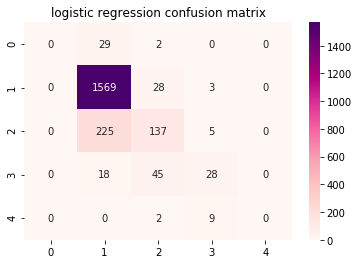

In [32]:
# LOGISTIC REGRESSION 
# initiate model
logreg = LogisticRegression(solver='liblinear', random_state=0)

# fit model
logreg.fit(x_train, y_train)

# computing predictions
log_pred = logreg.predict(x_test)

# compute accuracy score
log_accuracy = accuracy_score(y_test, log_pred)

# computing the confusion matrix
cm = confusion_matrix(y_test, log_pred)

# visualize confusion matrix
cm_matrix = pd.DataFrame(data=cm)

# plot of the matrix
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdPu')
plt.title('logistic regression confusion matrix')

# compute accuracy score
print('model accuracy score: ' + str(log_accuracy))

model accuracy score: 0.8371428571428572


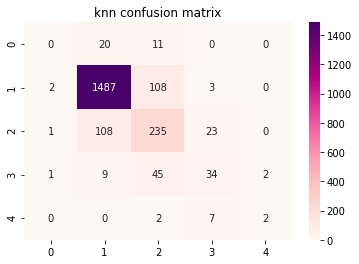

In [33]:
# K NEAREST NEIGHBOURS 
# instantiate the model
knn = KNeighborsClassifier(n_neighbors = 5)

# fit the model
knn.fit(x_train, y_train)

# compute predictions 
knn_pred = knn.predict(x_test)

# compute accuracy score
knn_accuracy = accuracy_score(y_test, knn_pred)

# compute confusion matrix
cm = confusion_matrix(y_test, knn_pred)

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm)

# create confusion matrix 
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdPu')
plt.title('knn confusion matrix')

# compute accuracy score
print('model accuracy score: ' + str(knn_accuracy))

model accuracy score: 0.8038095238095239


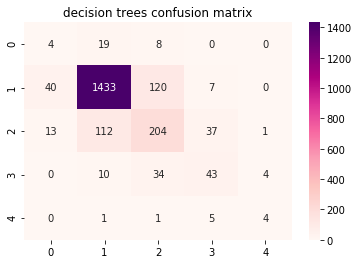

In [34]:
# DECISION TREES
# instantiate the model
dtree = DecisionTreeClassifier(random_state = 0)

# fit the model
dtree.fit(x_train, y_train)

# compute predictions 
dtree_pred = dtree.predict(x_test)

# compute accuracy score
dtree_accuracy = accuracy_score(y_test, dtree_pred)

# compute confusion matrix
cm = confusion_matrix(y_test,dtree_pred)

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdPu')
plt.title('decision trees confusion matrix')

# compute accuracy score
print('model accuracy score: ' + str(dtree_accuracy))

model accuracy score: 0.84


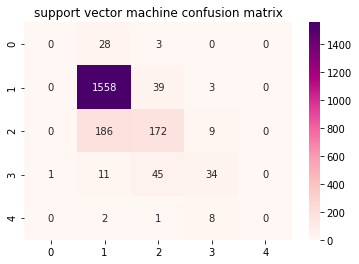

In [35]:
# SUPPORT VECTOR MACHINE
# instantiate the model
svm = make_pipeline(StandardScaler(), SVC(gamma = 'auto'))

# fit the model
svm.fit(x_train,y_train)

# compute predictions 
svm_pred = svm.predict(x_test)

# compute accuracy score
svm_accuracy = accuracy_score(y_test, svm_pred)

# compute confusion matrix
cm = confusion_matrix(y_test, svm_pred)

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdPu')
plt.title('support vector machine confusion matrix')

# compute accuracy score
print('model accuracy score: ' + str(svm_accuracy))

In [36]:
# MODEL SUMMARY COMPARISON
print('logistic regression accuracy score: ' + str(log_accuracy))
print('knn accuracy score: ' + str(knn_accuracy))
print('decision tree accuracy score: ' + str(dtree_accuracy))
print('svm accuracy score: ' + str(svm_accuracy))

logistic regression accuracy score: 0.8257142857142857
knn accuracy score: 0.8371428571428572
decision tree accuracy score: 0.8038095238095239
svm accuracy score: 0.84


The performance of models classifying the data into five class labels is much worse compared to a binary classification. The best performing model is still logistic binary classification, with the highest accuracy score